## Install and import dependencies

[TensorFlow Datasets](https://www.tensorflow.org/datasets/), an API that simplifies downloading and accessing datasets, and provides several sample datasets to work with.

In [1]:
!pip install -U tensorflow_datasets

Requirement already up-to-date: tensorflow_datasets in /usr/local/lib/python3.6/dist-packages (1.1.0)


In [2]:
import tensorflow as tf
import tensorflow_datasets as tfds
tfds.disable_progress_bar()

W0728 01:54:46.139910 139782605707136 lazy_loader.py:50] 
The TensorFlow contrib module will not be included in TensorFlow 2.0.
For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
  * https://github.com/tensorflow/io (for I/O related ops)
If you depend on functionality not listed there, please file an issue.



In [0]:
import math
import numpy as np
import matplotlib.pyplot as plt

In [4]:
print(tf.__version__)

1.14.0


In [0]:
tf.enable_eager_execution()

In [0]:
import logging
logger = tf.get_logger()
logger.setLevel(logging.ERROR)

## Import the Fashion MNIST dataset

In [7]:
dataset, metadata = tfds.load('fashion_mnist', as_supervised=True, with_info=True)
train_dataset, test_dataset = dataset['train'], dataset['test']

W0728 01:54:46.715398 139782605707136 dataset_builder.py:439] Warning: Setting shuffle_files=True because split=TRAIN and shuffle_files=None. This behavior will be deprecated on 2019-08-06, at which point shuffle_files=False will be the default for all splits.


In [0]:
class_names = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat', 
               'Sandal',      'Shirt',   'Sneaker',  'Bag',   'Ankle boot']

### Explore the data

In [9]:
num_train_examples = metadata.splits['train'].num_examples
num_test_examples = metadata.splits['test'].num_examples
print("Number of training examples: {}".format(num_train_examples))
print("Number of test examples: {}".format(num_test_examples))

Number of training examples: 60000
Number of test examples: 10000


## Preprocess the data

In [0]:
# Apply the normalization to each element in the train and test datasets
def normalize(images, labels):
    return tf.cast(images, tf.float32) / 255, labels

train_dataset = train_dataset.map(normalize)
test_dataset = test_dataset.map(normalize)

### Explore the precessed data

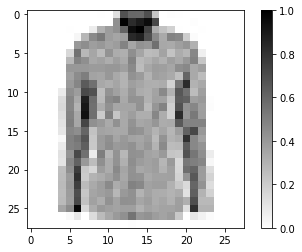

In [11]:
# Take a single image, and remove the color dimension by reshaping
for image, label in test_dataset.take(1):
    break
image = image.numpy().reshape((28, 28))

plt.figure()
plt.imshow(image, cmap=plt.cm.binary)
plt.colorbar()
plt.grid(False)
plt.show()

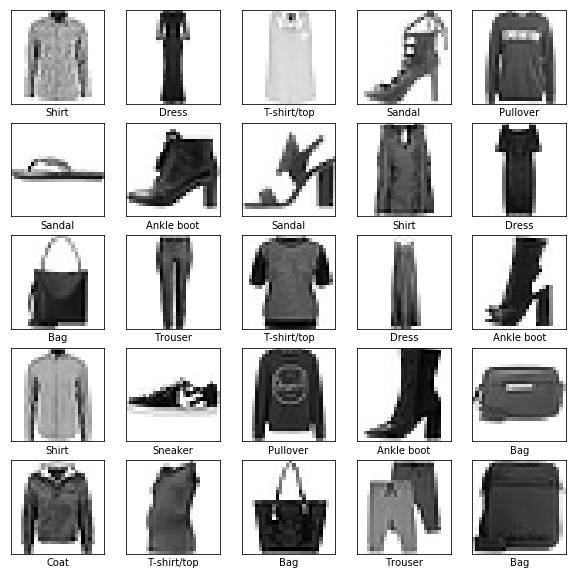

In [12]:
plt.figure(figsize=(10,10))
i = 0
for image, label in test_dataset.take(25):
    image = image.numpy().reshape((28, 28))
    plt.subplot(5, 5, i + 1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(image, cmap=plt.cm.binary)
    plt.xlabel(class_names[label])
    i += 1
plt.show()

## Build the model

Building the neural network requires configuring the layers of the model, then compiling the model.

### Setup the Layers

In [0]:
model = tf.keras.Sequential([
    tf.keras.layers.Flatten(input_shape=(28, 28, 1)),
    tf.keras.layers.Dense(128, activation=tf.nn.relu),
    tf.keras.layers.Dense(10, activation=tf.nn.softmax)
])

### Compile the model

Before the model is ready for traning, it needs a few more settings.

+ Loss function
+ Optimizer
+ Metrics - Used to monitor the traning and testing steps.

In [0]:
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

## Train the model

In [0]:
BATCH_SIZE = 32
train_dataset = train_dataset.repeat().shuffle(num_train_examples).batch(BATCH_SIZE)
test_dataset = test_dataset.batch(BATCH_SIZE)

In [16]:
model.fit(train_dataset, epochs=5, steps_per_epoch=math.ceil(num_train_examples / BATCH_SIZE))

Epoch 1/5
1875/1875 [==============================] - 22s 12ms/step - loss: 0.4969 - acc: 0.8249
Epoch 2/5
1875/1875 [==============================] - 14s 7ms/step - loss: 0.3767 - acc: 0.8637
Epoch 3/5
1875/1875 [==============================] - 14s 8ms/step - loss: 0.3372 - acc: 0.8766
Epoch 4/5
1875/1875 [==============================] - 14s 8ms/step - loss: 0.3146 - acc: 0.8844
Epoch 5/5
1875/1875 [==============================] - 14s 8ms/step - loss: 0.2952 - acc: 0.8900


## Evaluate accuracy

In [17]:
test_loss, test_accuracy = model.evaluate(test_dataset, steps=math.ceil(num_test_examples / 32))
print("Accuracy on test dataset: ", test_accuracy)

313/313 [==============================] - 2s 6ms/step - loss: 0.3913 - acc: 0.8572
Accuracy on test dataset:  0.8572


## Make predictions and explore

In [0]:
for test_images, test_labels in test_dataset.take(1):
    test_images = test_images.numpy()
    test_labels = test_labels.numpy()
    predictions = model.predict(test_images)

In [19]:
predictions.shape

(32, 10)

In [20]:
predictions[0]

array([6.3952517e-05, 1.7435381e-08, 4.1460760e-02, 9.8798759e-05,
       5.2710235e-02, 2.9943510e-07, 9.0565974e-01, 3.9462305e-09,
       6.1084961e-06, 1.1424177e-08], dtype=float32)

In [21]:
print(np.argmax(predictions[0]) == test_labels[0])

True


In [0]:
def plot_image(i, predictions_array, true_labels, images):
    predictions_array, true_label, img = predictions_array[i], true_labels[i], images[i]
    plt.grid(False)
    plt.xticks([])
    plt.yticks([])

    plt.imshow(img[..., 0], cmap=plt.cm.binary)

    predicted_label = np.argmax(predictions_array)
    color = 'blue' if predicted_label == true_label else 'red'

    plt.xlabel("{} {:2.0f}% ({})".format(class_names[predicted_label],
                                         100 * np.max(predictions_array),
                                         class_names[true_label]),
               color = color)

In [0]:
def plot_value_array(i, predictions_array, true_label):
    predictions_array, true_label = predictions_array[i], true_label[i]
    plt.grid(False)
    plt.xticks([])
    plt.yticks([])
    this_plot = plt.bar(range(10), predictions_array, color="#777777")
    plt.ylim([0, 1])
    predicted_label = np.argmax(predictions_array)

    this_plot[predicted_label].set_color('red')
    this_plot[true_label].set_color('blue')

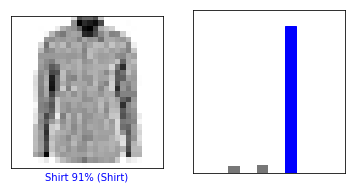

In [24]:
i = 0
plt.figure(figsize=(6, 3))
plt.subplot(1, 2, 1)
plot_image(i, predictions, test_labels, test_images)
plt.subplot(1, 2, 2)
plot_value_array(i, predictions, test_labels)

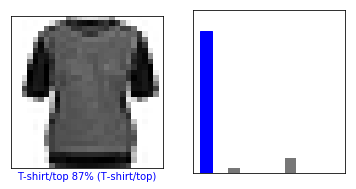

In [25]:
i = 12
plt.figure(figsize=(6, 3))
plt.subplot(1, 2, 1)
plot_image(i, predictions, test_labels, test_images)
plt.subplot(1, 2, 2)
plot_value_array(i, predictions, test_labels)

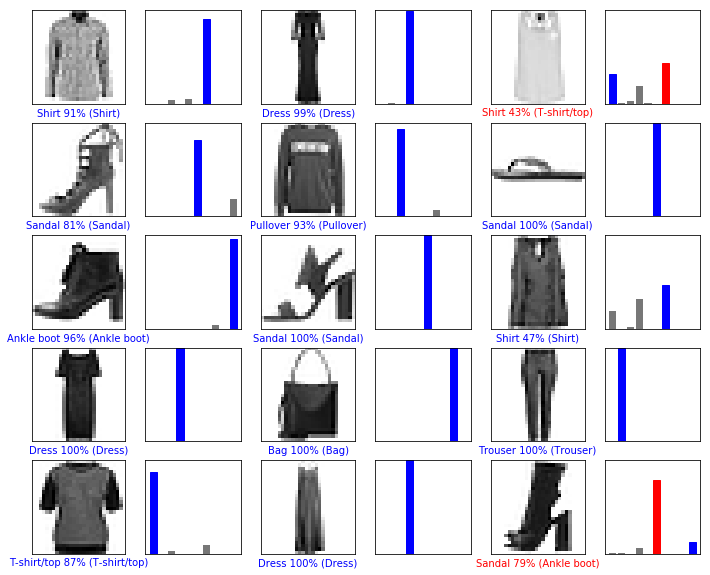

In [26]:
# Plot the first X test images, their predicted label, and the true label
# Color correct predictions in blue, incorrect predictions in red
num_rows = 5
num_cols = 3
num_images = num_rows * num_cols
plt.figure(figsize=(num_cols << 2, num_rows << 1))
for i in range(num_images):
    plt.subplot(num_rows, num_cols << 1, i << 1 | 1)
    plot_image(i, predictions, test_labels, test_images)
    plt.subplot(num_rows, num_cols << 1, (i << 1) + 2)
    plot_value_array(i, predictions, test_labels)

Finally, we can use the trained model to make a prediction about a single image.

In [0]:
def show_single_image(img):
    plt.figure()
    plt.imshow(img.reshape((28, 28)), cmap=plt.cm.binary)
    plt.colorbar()
    plt.grid(False)
    plt.show()

(28, 28, 1)


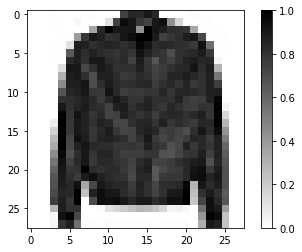

In [28]:
import random
idx = random.randint(0, 32 - 1) # Make a random selection
img = test_images[idx]
label = test_labels[idx]
print(img.shape)
show_single_image(img)

In [29]:
# Add the image to a batch where it's the only member.
img = np.array([img])
print(img.shape)

(1, 28, 28, 1)


Now predict the image

In [30]:
predictions_single = model.predict(img)
ans = np.argmax(predictions_single)
print("Prediction:", class_names[ans], "\nLabel:", class_names[label], "\nResult:", ans == label)

Prediction: Coat 
Label: Coat 
Result: True


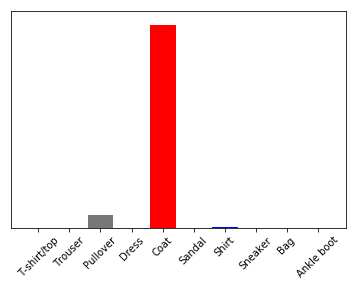

In [31]:
plot_value_array(0, predictions_single, test_labels)
_ = plt.xticks(range(10), class_names, rotation=45)

# Exercises
 
Experiment with different models and see how the accuracy results differ. In particular change the following parameters:
*   Set training epochs set to 1
*   Number of neurons in the Dense layer following the Flatten one. For example, go really low (e.g. 10) in ranges up to 512 and see how accuracy changes
*   Add additional Dense layers between the Flatten and the final Dense(10,  activation=tf.nn.softmax), experiment with different units in these layers
*   Don't normalize the pixel values, and see the effect that has
 
 
Remember to enable GPU to make everything run faster (Runtime -> Change runtime type -> Hardware accelerator -> GPU).
Also, if you run into trouble, simply reset the entire environment and start from the beginning:
*   Edit -> Clear all outputs
*   Runtime -> Reset all runtimes


### Set training epochs set to 1

In [32]:
# Define a new model and train & test it
temporary_model = tf.keras.Sequential([
    tf.keras.layers.Flatten(input_shape=(28, 28, 1)),
    tf.keras.layers.Dense(128, activation=tf.nn.relu),
    tf.keras.layers.Dense(10, activation=tf.nn.softmax)
])

temporary_model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

temporary_model.fit(train_dataset, epochs=1, steps_per_epoch=math.ceil(num_train_examples / BATCH_SIZE))

test_loss, test_accuracy = temporary_model.evaluate(test_dataset, steps=math.ceil(num_test_examples / 32))
print("Accuracy on test dataset: ", test_accuracy)

313/313 [==============================] - 2s 6ms/step - loss: 0.4292 - acc: 0.8472
Accuracy on test dataset:  0.8472


### Number of neurons in the Dense layer following the Flatten one.

For example, go really low (e.g. 10) in ranges up to 512 and see how accuracy changes

In [33]:
# Define a new model and train & test it
# 10
temporary_model = tf.keras.Sequential([
    tf.keras.layers.Flatten(input_shape=(28, 28, 1)),
    tf.keras.layers.Dense(10, activation=tf.nn.relu),
    tf.keras.layers.Dense(10, activation=tf.nn.softmax)
])

temporary_model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

temporary_model.fit(train_dataset, epochs=5, steps_per_epoch=math.ceil(num_train_examples / BATCH_SIZE))

test_loss, test_accuracy = temporary_model.evaluate(test_dataset, steps=math.ceil(num_test_examples / 32))
print("Accuracy on test dataset: ", test_accuracy)

Epoch 1/5
1875/1875 [==============================] - 22s 12ms/step - loss: 0.6779 - acc: 0.7773
Epoch 2/5
1875/1875 [==============================] - 14s 8ms/step - loss: 0.4715 - acc: 0.8363
Epoch 3/5
1875/1875 [==============================] - 14s 7ms/step - loss: 0.4442 - acc: 0.8446
Epoch 4/5
1875/1875 [==============================] - 14s 8ms/step - loss: 0.4283 - acc: 0.8498
Epoch 5/5
313/313 [==============================] - 2s 6ms/step - loss: 0.4607 - acc: 0.8375
Accuracy on test dataset:  0.8375


In [34]:
# Define a new model and train & test it
# 256
temporary_model = tf.keras.Sequential([
    tf.keras.layers.Flatten(input_shape=(28, 28, 1)),
    tf.keras.layers.Dense(256, activation=tf.nn.relu),
    tf.keras.layers.Dense(10, activation=tf.nn.softmax)
])

temporary_model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

temporary_model.fit(train_dataset, epochs=5, steps_per_epoch=math.ceil(num_train_examples / BATCH_SIZE))

test_loss, test_accuracy = temporary_model.evaluate(test_dataset, steps=math.ceil(num_test_examples / 32))
print("Accuracy on test dataset: ", test_accuracy)

Epoch 1/5
1875/1875 [==============================] - 22s 12ms/step - loss: 0.4846 - acc: 0.8285
Epoch 2/5
1875/1875 [==============================] - 14s 8ms/step - loss: 0.3599 - acc: 0.8690
Epoch 3/5
1875/1875 [==============================] - 14s 8ms/step - loss: 0.3232 - acc: 0.8809
Epoch 4/5
1875/1875 [==============================] - 14s 8ms/step - loss: 0.3047 - acc: 0.8886
Epoch 5/5
313/313 [==============================] - 2s 6ms/step - loss: 0.3878 - acc: 0.8585
Accuracy on test dataset:  0.8585


In [35]:
# Define a new model and train & test it
# 512
temporary_model = tf.keras.Sequential([
    tf.keras.layers.Flatten(input_shape=(28, 28, 1)),
    tf.keras.layers.Dense(512, activation=tf.nn.relu),
    tf.keras.layers.Dense(10, activation=tf.nn.softmax)
])

temporary_model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

temporary_model.fit(train_dataset, epochs=5, steps_per_epoch=math.ceil(num_train_examples / BATCH_SIZE))

test_loss, test_accuracy = temporary_model.evaluate(test_dataset, steps=math.ceil(num_test_examples / 32))
print("Accuracy on test dataset: ", test_accuracy)

Epoch 1/5
1875/1875 [==============================] - 22s 12ms/step - loss: 0.4710 - acc: 0.8316
Epoch 2/5
1875/1875 [==============================] - 14s 7ms/step - loss: 0.3581 - acc: 0.8703
Epoch 3/5
1875/1875 [==============================] - 14s 7ms/step - loss: 0.3188 - acc: 0.8826
Epoch 4/5
1875/1875 [==============================] - 14s 8ms/step - loss: 0.2953 - acc: 0.8913
Epoch 5/5
313/313 [==============================] - 2s 6ms/step - loss: 0.3720 - acc: 0.8633
Accuracy on test dataset:  0.8633


### Add additional Dense layers between the Flatten and the final Dense

In [36]:
# Define a new model and train & test it
# 1 Additional Dense layers
temporary_model = tf.keras.Sequential([
    tf.keras.layers.Flatten(input_shape=(28, 28, 1)),
    tf.keras.layers.Dense(128, activation=tf.nn.relu),
    tf.keras.layers.Dense(128, activation=tf.nn.relu),
    tf.keras.layers.Dense(10, activation=tf.nn.softmax)
])

temporary_model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

temporary_model.fit(train_dataset, epochs=5, steps_per_epoch=math.ceil(num_train_examples / BATCH_SIZE))

test_loss, test_accuracy = temporary_model.evaluate(test_dataset, steps=math.ceil(num_test_examples / 32))
print("Accuracy on test dataset: ", test_accuracy)

Epoch 1/5
1875/1875 [==============================] - 23s 12ms/step - loss: 0.4840 - acc: 0.8271
Epoch 2/5
1875/1875 [==============================] - 15s 8ms/step - loss: 0.3599 - acc: 0.8689
Epoch 3/5
1875/1875 [==============================] - 14s 8ms/step - loss: 0.3255 - acc: 0.8802
Epoch 4/5
1875/1875 [==============================] - 15s 8ms/step - loss: 0.3066 - acc: 0.8860
Epoch 5/5
313/313 [==============================] - 2s 6ms/step - loss: 0.3618 - acc: 0.8722
Accuracy on test dataset:  0.8722


In [37]:
# Define a new model and train & test it
# 2 Additional Dense layers
temporary_model = tf.keras.Sequential([
    tf.keras.layers.Flatten(input_shape=(28, 28, 1)),
    tf.keras.layers.Dense(128, activation=tf.nn.relu),
    tf.keras.layers.Dense(128, activation=tf.nn.relu),
    tf.keras.layers.Dense(128, activation=tf.nn.relu),
    tf.keras.layers.Dense(10, activation=tf.nn.softmax)
])

temporary_model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

temporary_model.fit(train_dataset, epochs=5, steps_per_epoch=math.ceil(num_train_examples / BATCH_SIZE))

test_loss, test_accuracy = temporary_model.evaluate(test_dataset, steps=math.ceil(num_test_examples / 32))
print("Accuracy on test dataset: ", test_accuracy)

Epoch 1/5
1875/1875 [==============================] - 23s 12ms/step - loss: 0.4907 - acc: 0.8246
Epoch 2/5
1875/1875 [==============================] - 15s 8ms/step - loss: 0.3625 - acc: 0.8659
Epoch 3/5
1875/1875 [==============================] - 14s 8ms/step - loss: 0.3318 - acc: 0.8765
Epoch 4/5
1875/1875 [==============================] - 15s 8ms/step - loss: 0.3061 - acc: 0.8867
Epoch 5/5
313/313 [==============================] - 2s 6ms/step - loss: 0.3740 - acc: 0.8640
Accuracy on test dataset:  0.864


In [38]:
# Define a new model and train & test it
# 3 Additional Dense layers
temporary_model = tf.keras.Sequential([
    tf.keras.layers.Flatten(input_shape=(28, 28, 1)),
    tf.keras.layers.Dense(128, activation=tf.nn.relu),
    tf.keras.layers.Dense(128, activation=tf.nn.relu),
    tf.keras.layers.Dense(128, activation=tf.nn.relu),
    tf.keras.layers.Dense(10, activation=tf.nn.softmax)
])

temporary_model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

temporary_model.fit(train_dataset, epochs=5, steps_per_epoch=math.ceil(num_train_examples / BATCH_SIZE))

test_loss, test_accuracy = temporary_model.evaluate(test_dataset, steps=math.ceil(num_test_examples / 32))
print("Accuracy on test dataset: ", test_accuracy)

Epoch 1/5
1875/1875 [==============================] - 23s 12ms/step - loss: 0.4861 - acc: 0.8235
Epoch 2/5
1875/1875 [==============================] - 15s 8ms/step - loss: 0.3595 - acc: 0.8680
Epoch 3/5
1875/1875 [==============================] - 14s 8ms/step - loss: 0.3353 - acc: 0.8761
Epoch 4/5
1875/1875 [==============================] - 15s 8ms/step - loss: 0.3089 - acc: 0.8843
Epoch 5/5
313/313 [==============================] - 2s 6ms/step - loss: 0.3552 - acc: 0.8737
Accuracy on test dataset:  0.8737


### Don't normalize the pixel values

W0728 02:04:49.085104 139782605707136 dataset_builder.py:439] Warning: Setting shuffle_files=True because split=TRAIN and shuffle_files=None. This behavior will be deprecated on 2019-08-06, at which point shuffle_files=False will be the default for all splits.


Number of training examples: 60000
Number of test examples: 10000


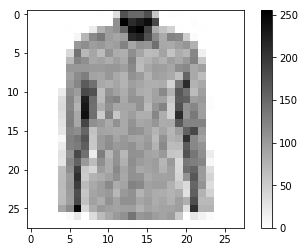

In [39]:
dataset, metadata = tfds.load('fashion_mnist', as_supervised=True, with_info=True)
train_dataset, test_dataset = dataset['train'], dataset['test']

num_train_examples = metadata.splits['train'].num_examples
num_test_examples = metadata.splits['test'].num_examples
print("Number of training examples: {}".format(num_train_examples))
print("Number of test examples: {}".format(num_test_examples))


# Take a single image, and remove the color dimension by reshaping
for image, label in test_dataset.take(1):
    break
image = image.numpy().reshape((28, 28))

plt.figure()
plt.imshow(image, cmap=plt.cm.binary)
plt.colorbar()
plt.grid(False)
plt.show()

In [40]:
model = tf.keras.Sequential([
    tf.keras.layers.Flatten(input_shape=(28, 28, 1)),
    tf.keras.layers.Dense(128, activation=tf.nn.relu),
    tf.keras.layers.Dense(10, activation=tf.nn.softmax)
])

model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

BATCH_SIZE = 32
train_dataset = train_dataset.repeat().shuffle(num_train_examples).batch(BATCH_SIZE)
test_dataset = test_dataset.batch(BATCH_SIZE)

model.fit(train_dataset, epochs=5, steps_per_epoch=math.ceil(num_train_examples / BATCH_SIZE))

test_loss, test_accuracy = model.evaluate(test_dataset, steps=math.ceil(num_test_examples / 32))
print("Accuracy on test dataset: ", test_accuracy)

Epoch 1/5
1875/1875 [==============================] - 20s 10ms/step - loss: 12.9337 - acc: 0.1974
Epoch 2/5
1875/1875 [==============================] - 12s 6ms/step - loss: 12.8891 - acc: 0.2003
Epoch 3/5
1875/1875 [==============================] - 12s 6ms/step - loss: 12.9334 - acc: 0.1976
Epoch 4/5
1875/1875 [==============================] - 12s 6ms/step - loss: 12.8824 - acc: 0.2007
Epoch 5/5
313/313 [==============================] - 2s 6ms/step - loss: 12.9031 - acc: 0.1993
Accuracy on test dataset:  0.1993
